This notebook built a 1d-CNN model to predict the soil element fraction, which is a point predict.

In [1]:
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchinfo import summary

## Data Preprocess

In [2]:
root_dir = "/unix/erw/data/24-07-25/batch_output"
root_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(".root")]

all_elements = set()
for path in root_files:
    with uproot.open(path) as file:
        # set(elements)
        df = file["Materials"].arrays(library="pd")
        all_elements.update(df["Element"].unique())
        
element_list = sorted(list(all_elements))
print(element_list)
element_to_index = {el: i for i, el in enumerate(element_list)}


X = [] 
Y = [] 

for path in root_files:
    with uproot.open(path) as file:

        spectrum = file["Edep (noise)"].values()
        #spectrum = file["Edep"].values()

        # min-max scale normalization
        spectrum_min = np.min(spectrum)
        spectrum_max = np.max(spectrum)
        if spectrum_max > spectrum_min:
            spectrum = (spectrum - spectrum_min) / (spectrum_max - spectrum_min)
        else:
            spectrum = np.zeros_like(spectrum)

        spectrum = spectrum.astype(np.float32)
        X.append(spectrum)

        df = file["Materials"].arrays(library="pd")
        df = df.drop_duplicates()              # (!) Don't forget!!!
        target = np.zeros(len(element_list), dtype=np.float32)
        for _, row in df.iterrows():
            idx = element_to_index[row["Element"]]
            target[idx] += row["Fraction"]
        Y.append(target)


X = torch.tensor(np.stack(X)).unsqueeze(1)     # shape: [N, 1, 1440]
Y = torch.tensor(np.stack(Y))                  # shape: [N, num_elements]

# Check data
i = 0  

print("\nX shape:", X.shape) 
print(f"X[{i}][:20] values:\n", X[i][0][:20]) 

print("\nY shape:", Y.shape) 
print(f"Y[{i}] values:\n", Y[i])

print("\nElement：")
for idx, frac in enumerate(Y[i]):
    print(f"{element_list[idx]}: {frac.item():.4f}")

['C', 'O', 'Si']

X shape: torch.Size([1000, 1, 1440])
X[0][:20] values:
 tensor([1.0000, 0.9749, 0.9644, 0.9733, 0.8923, 0.9320, 0.9474, 0.9215, 0.8761,
        0.8955, 0.8130, 0.8761, 0.7943, 0.7927, 0.8089, 0.8138, 0.8081, 0.7806,
        0.7522, 0.7312])

Y shape: torch.Size([1000, 3])
Y[0] values:
 tensor([0.0464, 0.5079, 0.4457])

Element：
C: 0.0464
O: 0.5079
Si: 0.4457


## 1D-CNN Structure

In [3]:
class CNN(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()

        self.conv_layers = nn.Sequential(
            # at least 3 conv, 2 can't learn...
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=9, padding=4),   # [B, 32, 1440]
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 32, 720]

            nn.Conv1d(32, 64, kernel_size=7, padding=3),  # [B, 64, 720]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 64, 360]

            nn.Conv1d(64, 128, kernel_size=3, padding=1), # [B, 128, 360]
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 128, 180] #avg
        )

        self.flatten_dim = 128 * 180  # update it if input structure changes

        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            #nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.ReLU(),
            #nn.Dropout(0.3),

            nn.Linear(128, num_outputs)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)   # flatten
        x = self.fc_layers(x)
        return F.softmax(x, dim=1)  # normalize


In [4]:
class cCNN(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=9, padding=4),   # [B, 64, 1440]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),                  # [B, 32, 360]

            nn.Conv1d(64, 128, kernel_size=7, padding=3),  # [B, 128, 360]
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 128, 180]
        )

        self.flatten_dim = 128 * 180  # update it if input structure changes

        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_dim, 258),
            nn.ReLU(),
            #nn.Dropout(0.3),

            nn.Linear(258, 64),
            nn.ReLU(),
            #nn.Dropout(0.3),

            nn.Linear(64, num_outputs)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)   # flatten
        x = self.fc_layers(x)
        return F.softmax(x, dim=1)  # normalize


In [5]:
# Hyperparameter (grid search in future)
batch_size = 64
epochs = 20
learning_rate = 1e-4

In [6]:
# Split dataset (80% training, 20% validation)
dataset = TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [7]:
# Initialization
model = cCNN(num_outputs=Y.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()   # (?)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

summary(model, input_size=(batch_size, 1, 1440))

Layer (type:depth-idx)                   Output Shape              Param #
cCNN                                     [64, 3]                   --
├─Sequential: 1-1                        [64, 128, 180]            --
│    └─Conv1d: 2-1                       [64, 64, 1440]            640
│    └─BatchNorm1d: 2-2                  [64, 64, 1440]            128
│    └─ReLU: 2-3                         [64, 64, 1440]            --
│    └─MaxPool1d: 2-4                    [64, 64, 360]             --
│    └─Conv1d: 2-5                       [64, 128, 360]            57,472
│    └─BatchNorm1d: 2-6                  [64, 128, 360]            256
│    └─ReLU: 2-7                         [64, 128, 360]            --
│    └─MaxPool1d: 2-8                    [64, 128, 180]            --
├─Sequential: 1-2                        [64, 3]                   --
│    └─Linear: 2-9                       [64, 258]                 5,944,578
│    └─ReLU: 2-10                        [64, 258]                 --
│

## Model Training

Epoch 1/20 | Train Loss: 0.00562 | Val Loss: 0.00894
Epoch 2/20 | Train Loss: 0.00135 | Val Loss: 0.00113
Epoch 3/20 | Train Loss: 0.00106 | Val Loss: 0.00190
Epoch 4/20 | Train Loss: 0.00046 | Val Loss: 0.00111
Epoch 5/20 | Train Loss: 0.00042 | Val Loss: 0.00112
Epoch 6/20 | Train Loss: 0.00038 | Val Loss: 0.00047
Epoch 7/20 | Train Loss: 0.00036 | Val Loss: 0.00040
Epoch 8/20 | Train Loss: 0.00034 | Val Loss: 0.00035
Epoch 9/20 | Train Loss: 0.00032 | Val Loss: 0.00033
Epoch 10/20 | Train Loss: 0.00030 | Val Loss: 0.00030
Epoch 11/20 | Train Loss: 0.00027 | Val Loss: 0.00027
Epoch 12/20 | Train Loss: 0.00024 | Val Loss: 0.00023
Epoch 13/20 | Train Loss: 0.00020 | Val Loss: 0.00023
Epoch 14/20 | Train Loss: 0.00018 | Val Loss: 0.00017
Epoch 15/20 | Train Loss: 0.00015 | Val Loss: 0.00014
Epoch 16/20 | Train Loss: 0.00012 | Val Loss: 0.00012
Epoch 17/20 | Train Loss: 0.00010 | Val Loss: 0.00009
Epoch 18/20 | Train Loss: 0.00007 | Val Loss: 0.00007
Epoch 19/20 | Train Loss: 0.00006 | V

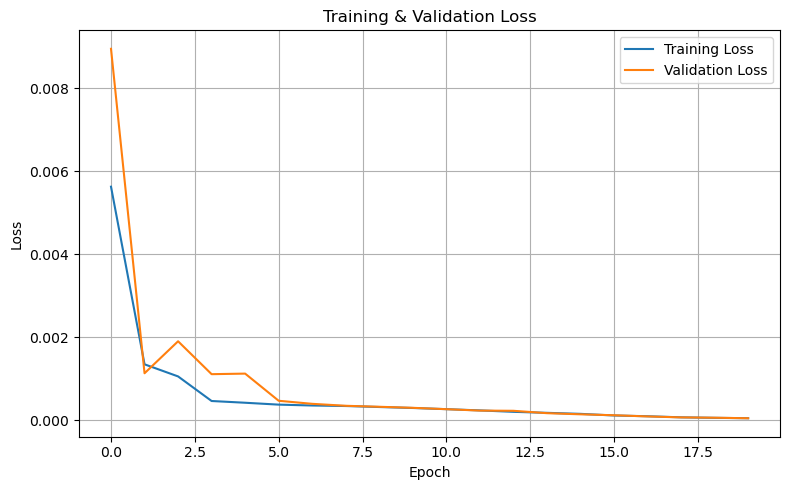

In [8]:
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        preds = model(batch_X) 
        loss = criterion(preds, batch_Y) 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_Y in val_loader:
            val_X, val_Y = val_X.to(device), val_Y.to(device)
            preds = model(val_X)
            loss = criterion(preds, val_Y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")

# plot
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Evaluation

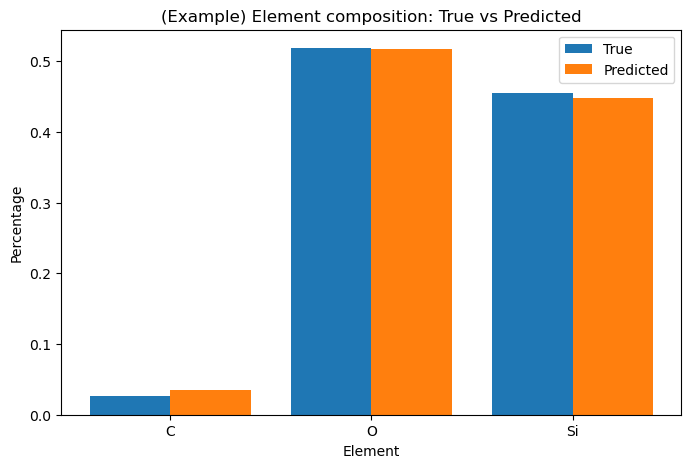

In [9]:
# Choose one random example from validation set
model.eval()

with torch.no_grad():
    for val_X, val_Y in val_loader:
        val_X, val_Y = val_X.to(device), val_Y.to(device)

        # take one sample
        preds = model(val_X)            # [B, num_elements]
        pred_probs = preds[15].cpu()
        true_probs = val_Y[15].cpu()

        # plot
        x = torch.arange(len(true_probs))
        element_names = element_list

        plt.figure(figsize=(8, 5))
        plt.bar(x - 0.2, true_probs, width=0.4, label='True')
        plt.bar(x + 0.2, pred_probs, width=0.4, label='Predicted')
        plt.xlabel("Element")
        plt.ylabel("Percentage")
        plt.title("(Example) Element composition: True vs Predicted")
        plt.xticks(x, element_names)
        plt.legend()
        plt.show()
        break  # just show one sample

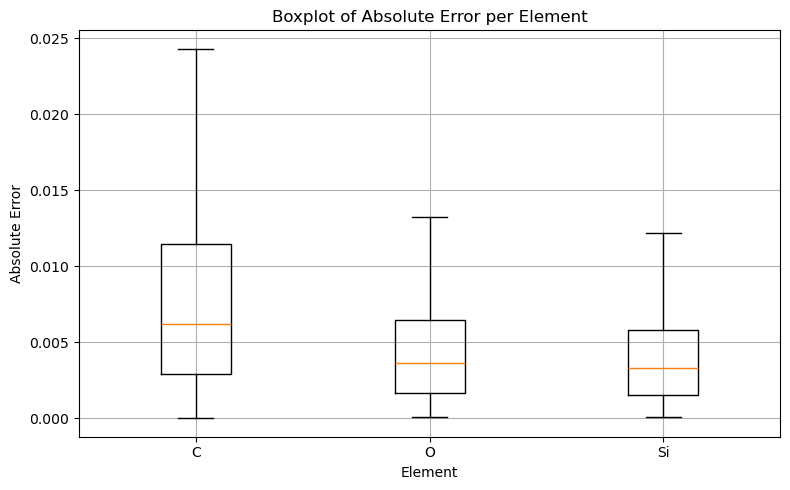

In [10]:
# Boxplot of abs error
model.eval()

abs_errors = []

all_true = []
all_pred = []

with torch.no_grad():
    for val_X, val_Y in val_loader:
        val_X, val_Y = val_X.to(device), val_Y.to(device)
        preds = model(val_X)
        preds = preds.cpu()
        val_Y = val_Y.cpu()

        all_true.append(val_Y)
        all_pred.append(preds)


true_all = torch.cat(all_true, dim=0)
pred_all = torch.cat(all_pred, dim=0)

abs_errors = torch.abs(pred_all - true_all).numpy()  # shape: [N, num_elements]

# boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(abs_errors, tick_labels=element_list, showfliers=False)
plt.ylabel("Absolute Error")
plt.xlabel("Element")
plt.title("Boxplot of Absolute Error per Element")
plt.grid(True)
plt.tight_layout()
plt.show()


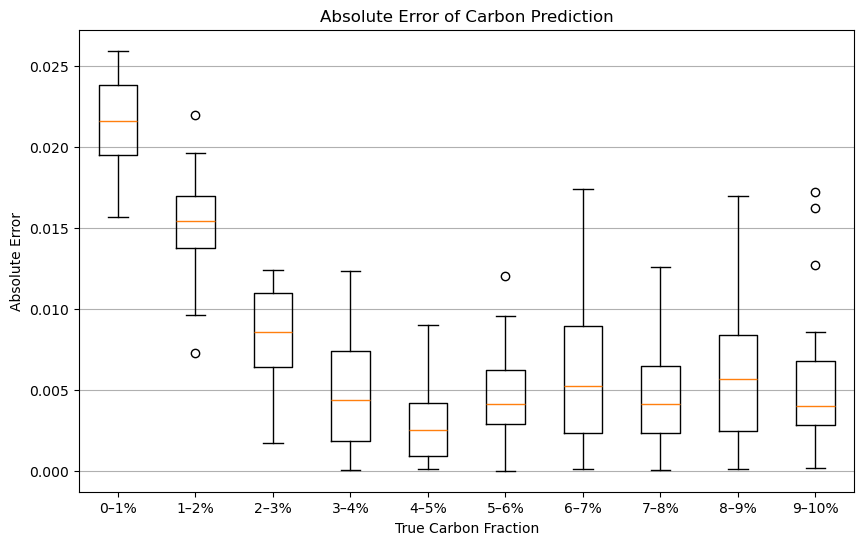

In [11]:
carbon_index = 0
true_C = true_all[:, carbon_index].numpy()
pred_C = pred_all[:, carbon_index].numpy()
abs_errors = np.abs(true_C - pred_C)

# bins：0-1%, 1-2%, ..., 9-10%
bins = np.linspace(0, 0.1, 11)
bin_labels = [f"{int(b*100)}–{int(bins[i+1]*100)}%" for i, b in enumerate(bins[:-1])]

# Split samples by bins
bin_indices = np.digitize(true_C, bins) - 1  # bin index from 0 to 9

# Collect abs error in each bin
grouped_errors = [[] for _ in range(len(bins) - 1)]
for idx, err in zip(bin_indices, abs_errors):
    if 0 <= idx < len(grouped_errors):
        grouped_errors[idx].append(err)

# plot
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_errors, tick_labels=bin_labels, showfliers=True)
plt.xlabel("True Carbon Fraction")
plt.ylabel("Absolute Error")
plt.title("Absolute Error of Carbon Prediction")
plt.grid(True, axis="y")
plt.show()

### Distribution and Error Analysis by Carbon Fraction

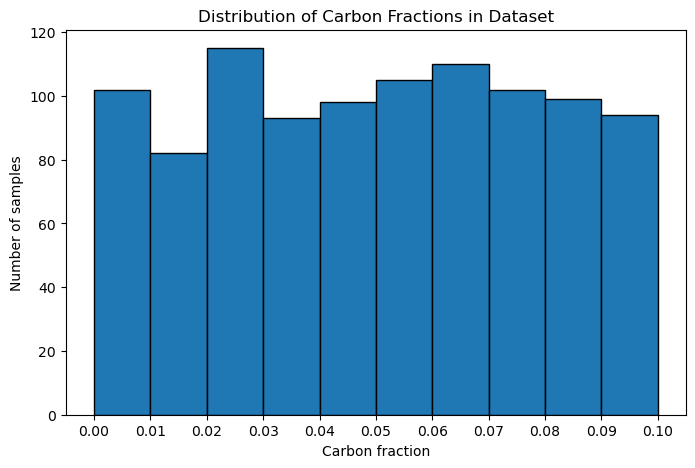

In [11]:
carbon_fractions = Y[:, 0].numpy()

bins = [i/100 for i in range(11)]

plt.figure(figsize=(8, 5))
plt.hist(carbon_fractions, bins=bins, edgecolor="black")
plt.xlabel("Carbon fraction")
plt.ylabel("Number of samples")
plt.title("Distribution of Carbon Fractions in Dataset")
plt.xticks(bins)
plt.show()

In [12]:
print(pred_all.shape)

torch.Size([200, 3])


(200,)


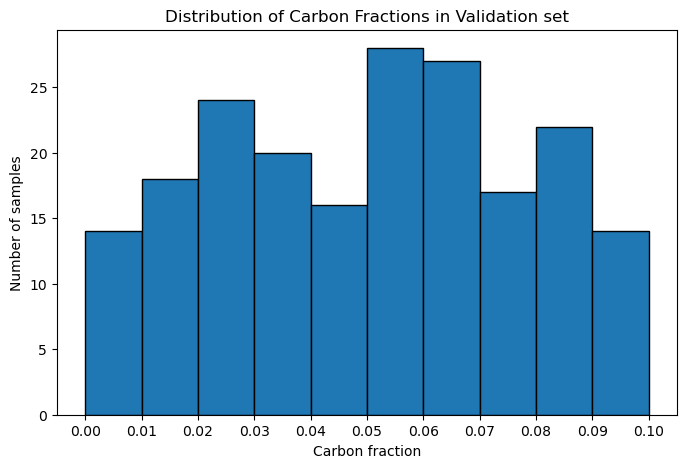

In [13]:
carbon_index = 0
true_c = true_all[:, carbon_index].numpy()
print(true_c.shape)

bins = [i/100 for i in range(11)]

plt.figure(figsize=(8, 5))
plt.hist(true_c, bins=bins, edgecolor="black")
plt.xlabel("Carbon fraction")
plt.ylabel("Number of samples")
plt.title("Distribution of Carbon Fractions in Validation set")
plt.xticks(bins)
plt.show()